In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Plotting Code for Fig 7: Helios End2End

In [2]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/helios_end2end.log').expanduser()
helios_df = utils.load_logs_as_dataframe(log_path)

In [3]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=3)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('constant', 0.25, -1): 'Constant-Wait + No-SJ',
    ('linear_capacity_filter_cpu', -1, -1): 'Resource-Wait',
    ('linear_cost_filter_cpu', -1, -1): 'Starburst',
    ('linear_capacity_filter_cpu', 0.25, 3): 'Starburst (No-TE)',
    ('zero', -1, -1): 'No-Wait',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (No-TE)': 'tab:purple',
    'Resource-Wait': 'tab:pink',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time.
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                # Hardcoded, precomputed ahead of time.
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        # 1 V100 GPU costs 2.5$/hour. So far, everything is normalized to 1.
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','s', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'zero' and label[1] !=-1:
            continue
        if label not in legend_dict:
            continue
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            if label == 'Starburst (No-TE)':
                pd.set_option('display.max_rows', None)
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()

    assert len(lines) == 5
    fig.legend([lines[4], lines[0], lines[1], lines[2], lines[3]], 
               [labels[4], labels[0], labels[1], labels[2], labels[3]], bbox_to_anchor=(0, 0.92, 1, 0.2),  ncol=len(labels),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios.pdf', bbox_inches='tight')
    plt.show()  

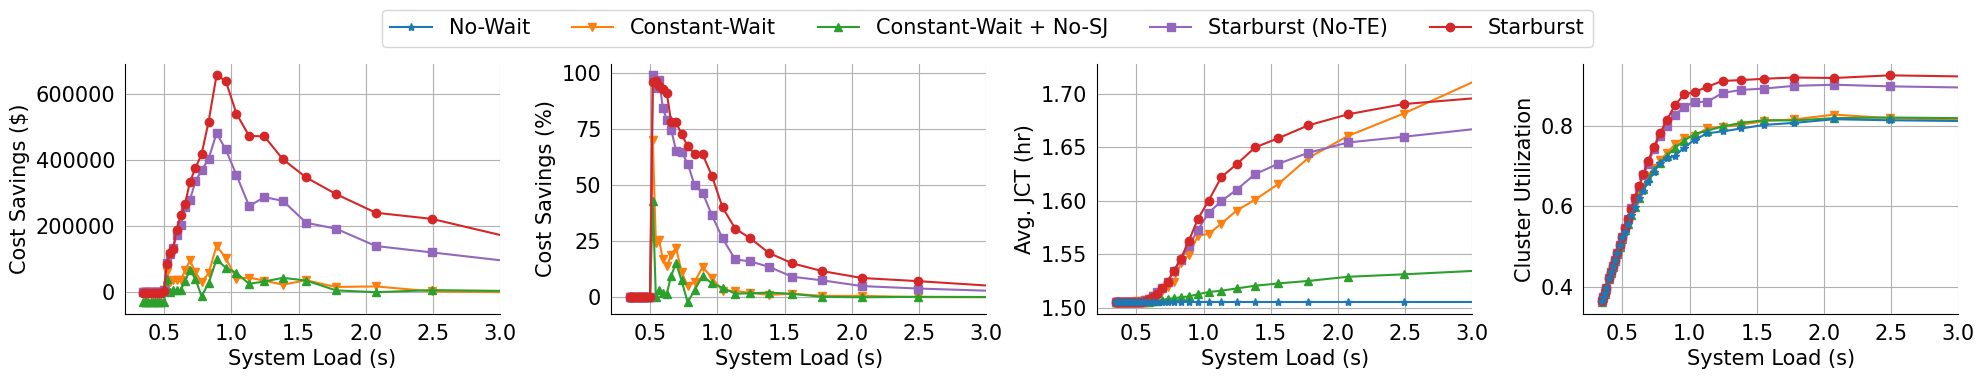

In [5]:
simulator_plotting_fn(helios_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero',},
                      # Groups baselines by waiting_policy x long_job_thres x preempt_cloud_ratio
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True) # Normalizes x-axis to system utilization.

# Plotting Code for Fig 7: Philly End2End

In [6]:
from pathlib import Path
# Replace path with the corresponding log file
log_path = Path('~/logs/philly_end2end.log').expanduser()
philly_df = utils.load_logs_as_dataframe(log_path)

In [9]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=3)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}


legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('constant', 0.25, -1): 'Constant-Wait + No-SJ',
    ('linear_capacity', -1, -1): 'Resource-Wait',
    ('linear_cost', -1, -1): 'Starburst',
    ('linear_capacity', 0.25, 3): 'Starburst (No-TE)',
    ('zero', -1, -1): 'No-Wait',

}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (No-TE)': 'tab:purple',
    'Resource-Wait': 'tab:pink',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait, happens at low system load (we should ignore this as this contains a lot of errors.)
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','s', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'zero' and label[1] !=-1:
            continue
        if label not in legend_dict:
            continue
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()

    fig.legend([lines[4], lines[0], lines[1], lines[2], lines[3]], 
               [labels[4], labels[0], labels[1], labels[2], labels[3]], bbox_to_anchor=(0, 0.92, 1, 0.2),  ncol=len(labels),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly.pdf', bbox_inches='tight')
    plt.show()  

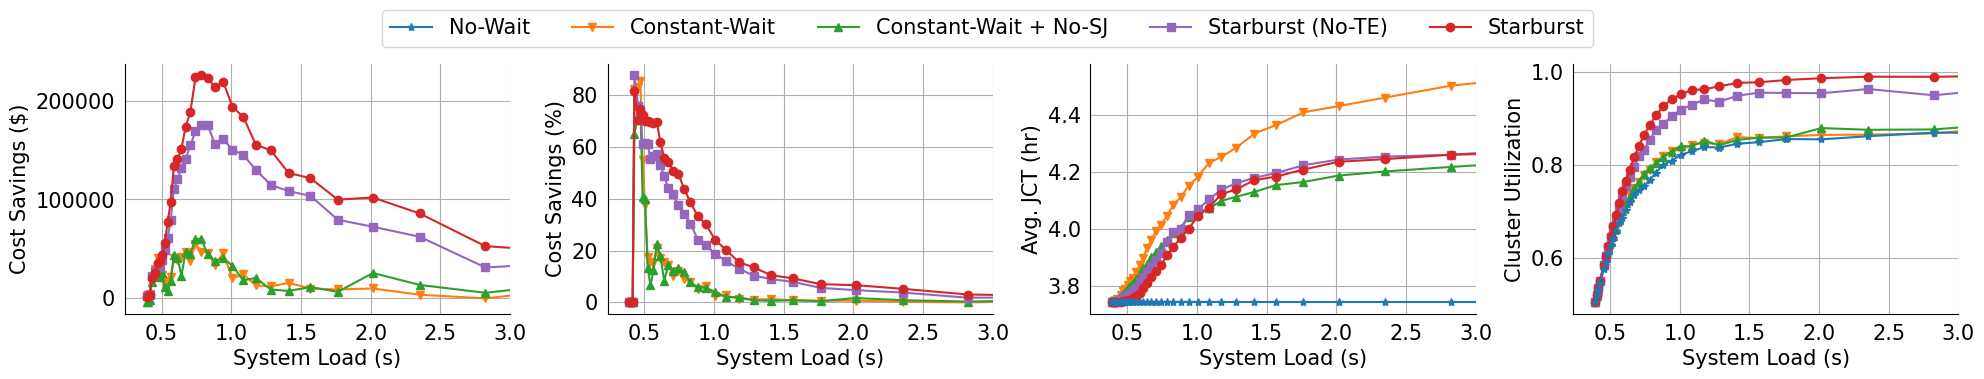

In [11]:

simulator_plotting_fn(philly_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero', 'long_job_thres': -1, 'loop': 0},
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True)